In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, MetaData
from sqlalchemy.orm import declarative_base
from sqlalchemy.orm import sessionmaker

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [7]:
# reflect an existing database into a new model
database_path = 'hawaii.sqlite.db'

Base = automap_base()

Base.prepare(autoload_with=engine)



In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Station= Base.classes.station
Measurement= Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
# Query the maximum date from the Measurement table
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print("Most recent date:", most_recent_date)


Most recent date: 2017-08-23


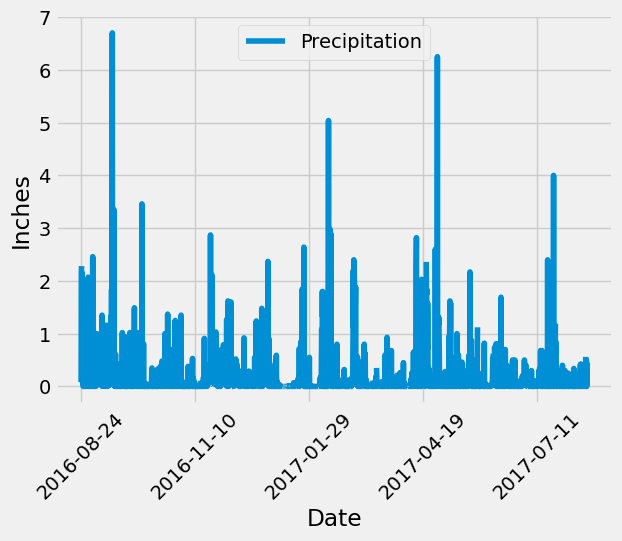

<Figure size 200x200 with 0 Axes>

In [45]:
# Sort the dataframe by date
from datetime import datetime, timedelta

most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year ago
one_year_ago = most_recent_date - timedelta(days=365)

# Query precipitation data within the last 12 months
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .order_by(Measurement.date).all()

# Save query results as a dataframe
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

df.plot(x='Date', y='Precipitation', rot=45)
plt.xlabel('Date')
plt.ylabel('Inches')
# Plot the precipitation data
plt.figure(figsize=(2, 2))
plt.tight_layout()



In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data

summary_stats = df['Precipitation'].describe()

summary_stats_df = pd.DataFrame(summary_stats)

summary_stats_df


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print("Total number of stations:", total_stations)

Total number of stations: 9


In [27]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station)).all()

# Reverse the list to get descending order
most_active_stations.reverse()

# Print the list of most active stations
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [28]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Query to find the most active station
most_active_station = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).first()

# Get the most active station ID
most_active_station_id = most_active_station[0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station_id).first()

# Print the temperature statistics
print(f"Most Active Station: {most_active_station_id}")
print(f"Lowest Temperature: {temperature_stats[0]}")
print(f"Highest Temperature: {temperature_stats[1]}")
print(f"Average Temperature: {temperature_stats[2]}")


Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


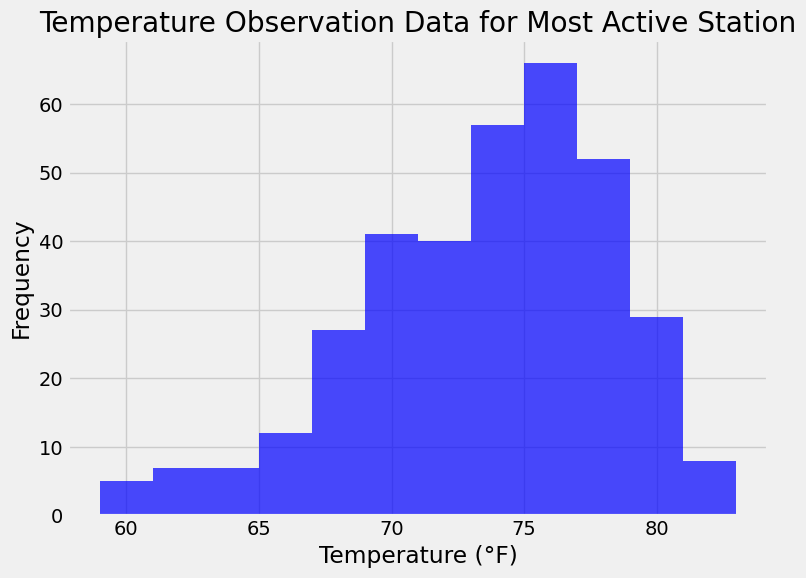

In [42]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id)\
    .filter(Measurement.date >= one_year_ago).all()
temperature_list = [temp[0] for temp in temperature_data]

plt.figure(figsize=(8, 6))
plt.hist(temperature_list, bins=12, color='blue', alpha=0.7)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for Most Active Station')
plt.tight_layout()
plt.show()

# Close Session

In [43]:
# Close Session
session.close()